# Importando o PDF

In [10]:
import pdfplumber

def pdfRead(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text() + '\n'
    return text

pdf_path = "aprendizado de maquina.pdf"
pdf_text = pdfRead(pdf_path=pdf_path)

print(f"[INFO] Tamanho do PDF em caracteres {len(pdf_text)}")

[INFO] Tamanho do PDF em caracteres 1908


## Adicionando Stop Words da API e agregando Stop Words customizadas

In [11]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') 

api_stop_words = set(stopwords.words('portuguese'))
# Analisando o texto cheguei a conclusão que essas são as stop words necessarias nesse PDF, uma frase que analisei foi 
# "O  aprendizado  supervisionado  ocorre  quando  os  conjuntos  de  exemplos  são 
# fornecidos  ao  sistema  com  suas  respectivas  classes,  com  isto  objetiva-se 
# classificar os novos conjuntos ainda não rotulados.""
# Nessa frase se vê o uso de 'com','de','ao','o','a' e 'com' apesar do set de stop words que utilizo possivelmente incluir elas, 
# prefiro ter certeza incluindo elas manualmente

my_stop_words = ["o","a","ao","com","os",'de']


used_stop_words = api_stop_words.union(my_stop_words)

print(f'[INFO] Total stopwords: {len(used_stop_words)}')
print(used_stop_words)

[INFO] Total stopwords: 207
{'há', 'já', 'sem', 'nós', 'terei', 'essa', 'minhas', 'na', 'da', 'te', 'um', 'você', 'estivessem', 'houvéssemos', 'fosse', 'tivesse', 'meus', 'elas', 'eram', 'muito', 'somos', 'à', 'é', 'seríamos', 'pela', 'que', 'estas', 'entre', 'estes', 'só', 'delas', 'no', 'houverem', 'me', 'estiverem', 'isso', 'houveremos', 'hajamos', 'aquela', 'esta', 'estivesse', 'vocês', 'fôssemos', 'tínhamos', 'houveria', 'numa', 'estivemos', 'pelos', 'tem', 'hão', 'também', 'nas', 'qual', 'mas', 'serão', 'depois', 'esteve', 'minha', 'houvesse', 'ser', 'teriam', 'estar', 'quando', 'estivéssemos', 'este', 'seriam', 'houvera', 'o', 'esses', 'houvéramos', 'estivera', 'houver', 'terá', 'ele', 'com', 'estava', 'nem', 'foi', 'nossos', 'tiveram', 'teria', 'tivéssemos', 'estiveram', 'foram', 'sou', 'dela', 'tiver', 'fomos', 'estivermos', 'estávamos', 'haver', 'mais', 'num', 'nosso', 'estavam', 'do', 'fossem', 'haja', 'suas', 'houverão', 'tenha', 'uma', 'não', 'houverá', 'teríamos', 'essas'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diurno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 

# Pré-Processamento do Texto e Limpeza

In [12]:
import re
import spacy

nlp = spacy.load('pt_core_news_sm')

def preprocess_text(text, print_tokens = False):
    text = text.lower()
    # Deixando o texto todo em letras minúsculas a fim de padronizar todo o texto
    # Manter diferenciais em caixa, pode levar a classificação de palavras como "Peixe" e "peixe" como palavras diferentes
    # Além de atrapalhar na remoção de stopwords
    text = re.sub(r'[^a-zà-ú0-9 .]', ' ', text) 
    # Remoção de números mas mantendo '.' para utilização no Chunking
    doc = nlp(text)

    tokens = [token.text for token in doc]

    # O PDF é literário 
    # A lematização é preferida para preservar o significado das palavras
    # Steeming iria perder muito a semantica das palavras.
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in used_stop_words and not token.is_punct]    
    
    if print_tokens:
        print(f'[INFO] Tokens Pré Lematização [10]: {tokens[:10]}')
        print(f'[INFO] Tokens Lematizados [10]: {cleaned_tokens[:10]}')

    final_text = ' '.join(cleaned_tokens)

    return final_text


preprocessed_text = preprocess_text(pdf_text, True)
    

print(f'[INFO] Tamanho do Texto Original: {len(pdf_text)}')
print(f'[INFO] Tamanho do Texto Pré-Processado: {len(preprocessed_text)}')

print(preprocessed_text[:500]) 

[INFO] Tokens Pré Lematização [10]: ['aprendizagem', 'de', 'máquina', 'o', 'aprendizado', 'de', 'máquina', ' ', 'am', ' ']
[INFO] Tokens Lematizados [10]: ['aprendizagem', 'máquina', 'aprendizado', 'máquina', ' ', 'Am', ' ', 'segmento', 'inteligência', 'artificial']
[INFO] Tamanho do Texto Original: 1908
[INFO] Tamanho do Texto Pré-Processado: 1521
aprendizagem máquina aprendizado máquina   Am   segmento inteligência artificial possuir elemento essencial comportamento inteligente   capacidade aprendizado área Am responsável pesquisar método computacional adequar aquisição novo conhecimento   novo habilidade novo forma organização conhecimento existente aprendizado possibilito sistema fazer mesmo tarefa tarefa sobre mesmo população maneira eficiente cada execução campo aprendizado máquina conceber questão construir programa   automaticament


## Transformando em Chunks utilizando Chunk Recursivo

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Números adquiridos ao testar os resultados dados pelo chunking em queries.
chunk_size = 200 
overlap_size = 40

# Decidi utilizar o chunking recursivo pois o PDF dado é bem estruturado em paragrafos, então acredito que uma divisão primeiramente 
# em paragrafos pode ajudar a manter a semantica.
# Apesar de que também acredito que um Chunking Fixo possa funcionar no exemplo dado, 
# prefiro utilizar a estrutura do PDF para melhorar o chunking
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n",".", " ", ""], # Separa em Paragrafos, linhas, frases separadas por ponto, palavras e em caracteres.
    chunk_size=chunk_size,
    chunk_overlap=overlap_size,
)

text_chunks = text_splitter.split_text(preprocessed_text)

print(f'[INFO] Número de Chunks: {len(text_chunks)}')

[INFO] Número de Chunks: 10


# Embedding e Inserção no Banco Vetorial

In [14]:
from sentence_transformers import SentenceTransformer
import chromadb 

client = chromadb.Client()

# Modelo generalista, de acordo com minha pesquisa pessoal esse modelo funcionaria melhor sem lematização e sem remoção de acentos
# Então preferi ficar no meio termo e só lematizar, ainda mais que é um requisito da prova.
model_name = 'all-MiniLM-L6-v2' 

model = SentenceTransformer(
    model_name
)
print("[INFO] Encoding Chunks")


# Realizando Embeddings utilizando o all-MiniLM
embeddings = model.encode(text_chunks, show_progress_bar=True)

ids = [f'chunk_{i}' for i in range(len(text_chunks))]
collection_name = 'pdf_chunks'

if collection_name in [col.name for col in client.list_collections()]:
    print(f"[INFO]  Deletando Coleção com o nome: '{collection_name}' ")
    client.delete_collection(name=collection_name)
    print(f"[SUCESS]  Coleção deletada com sucesso: '{collection_name}' ")

print(f"[INFO] Criando Coleção com o nome: '{collection_name}'")
collection = client.create_collection(name=collection_name, metadata={"hnsw:space": "cosine"}) 
# Configuração para fazer com que o ChromaDB utilize cosseno no seu calculo de distancia, alinhando 
# com o Modelo utilizado para dar encoding nos embeddings, já que a série de modelos MiniLM utilizam cosseno.

collection.add(
    ids=ids,
    documents=text_chunks,
    embeddings=embeddings.tolist()
)
    

[INFO] Encoding Chunks


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

[INFO]  Deletando Coleção com o nome: 'pdf_chunks' 
[SUCESS]  Coleção deletada com sucesso: 'pdf_chunks' 
[INFO] Criando Coleção com o nome: 'pdf_chunks'


# Consulta 1

[INFO] Embedding Query


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 70.67it/s]

[INFO] Melhor Resultado da Query : 'O que é aprendizado de maquina?'
[INFO] Resultado: aprendizagem máquina aprendizado máquina   Am   segmento inteligência artificial possuir elemento essencial comportamento inteligente   capacidade aprendizado área Am responsável pesquisar método... 
distance: 0.4930



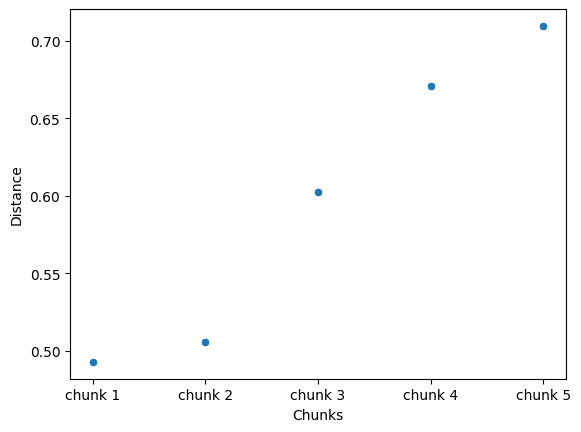

In [15]:
import seaborn as sb 
import matplotlib.pyplot as plt

raw_query = "O que é aprendizado de maquina?"
# Pergunta escolhida por ser diretamente respondida no PDF
# A distancia dada do resultado foi de 0.49
# O resultado contém a resposta do que é Aprendizado de Máquina,
# Dando "aprendizagem máquina aprendizado máquina   Am   segmento inteligência artificial possuir elemento
#  essencial comportamento inteligente   capacidade aprendizado área Am responsável pesquisar método..."
# O que inclui a resposta


query = preprocess_text(raw_query)
print("[INFO] Embedding Query")
# O encode da Query utiliza o mesmo modelo usado para dar encoding nos chunks, isso facilita na busca no banco vetorial.
query_embedding = model.encode([query], show_progress_bar=True)

results = collection.query(query_embeddings=query_embedding.tolist(), n_results=5, include=['documents','distances'])

# Melhor Resultado da Query e sua distancia 

# A Query não dá diretamente a resposta, mas traz o chunk mais relevante e com informações sobre o que foi perguntado, 
# no caso uma resposta mais "precisa" seria realizada se o chunk fosse menor 
# ou se o contexto fosse passado para uma IA de linguagem natural,
#  onde ela utilizaria de contexto e responderia de uma forma mais "humana"

print(f"[INFO] Melhor Resultado da Query : '{raw_query}'")
print(f"[INFO] Resultado: {results['documents'][0][0][:500]}...",f"\ndistance: {results['distances'][0][0]:.4f}\n")

# Plot para visualizar as distâncias dos chunks retornados
# A Distancia é a distância do embedding da query para o embedding do chunk, quanto mais próximo de 0, 
# mais relevante o chunk é a query, no caso do modelo utilizado (all-MiniLM-L6-v2) 
# a distancia é calculada via cosseno

# Normalmente o ChromaDB utiliza um calculo de distancia Euclidiano, mas para 
# alinhar com o modelo preferi mudar a configuração para utilizar o cosseno, valores de 0-2 ( 2 sendo completamente opostos ).

sb.scatterplot(x=[f'chunk {i+1}' for i in range(len(results['distances'][0]))], y=results['distances'][0])
plt.ylabel('Distance')
plt.xlabel('Chunks')
plt.show()

# Consulta 2

[INFO] Embedding Query


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 65.81it/s]

[INFO] Melhor Resultado da Query : 'O que é Regressão?'
[INFO] Resultado: Pré definir    regressão   previsão valor numérico contínuor algoritmo aprendizar   indutor   receber conjunto exemplo treinamento qual rótulo classe associar conhecer cada exemplo   instância padrão... 
distance: 0.5238



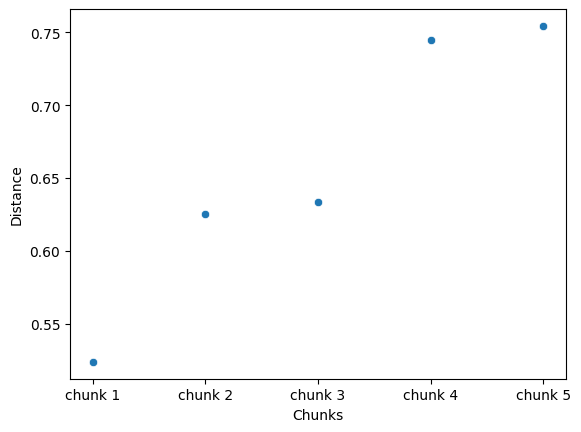

In [16]:
import seaborn as sb 
import matplotlib.pyplot as plt

raw_query = "O que é Regressão?"
# Pergunta escolhida por ser algo diretamente respondido pelo texto
# A distancia dada do resultado foi de 0.58
# O resultado contém a resposta do que é Regressão,
# incluindo '[...] regressão   previsão valor numérico contínuo ...'
# sendo a resposta no PDF  "Regressão: previsão de um valor numérico contínuo"

query = preprocess_text(raw_query)
print("[INFO] Embedding Query")

query_embedding = model.encode([query], show_progress_bar=True)

results = collection.query(query_embeddings=query_embedding.tolist(), n_results=5, include=['documents','distances'])


print(f"[INFO] Melhor Resultado da Query : '{raw_query}'")
print(f"[INFO] Resultado: {results['documents'][0][0][:500]}...",f"\ndistance: {results['distances'][0][0]:.4f}\n")


sb.scatterplot(x=[f'chunk {i+1}' for i in range(len(results['distances'][0]))], y=results['distances'][0])
plt.ylabel('Distance')
plt.xlabel('Chunks')
plt.show()

#